In [20]:
import numpy as np
import pandas as pd
import cmapPy.pandasGEXpress.parse_gctx as parse_gctx
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing as mp
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from IPython.display import HTML, display, Markdown
import umap

from bokeh.io import output_notebook
from bokeh.plotting import figure, show, save, output_file
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Category20
from bokeh.transform import factor_cmap
from bokeh.models import Label

import scanpy as sc
from maayanlab_bioinformatics.normalization import log2_normalize, filter_by_var
from maayanlab_bioinformatics.dge.characteristic_direction import characteristic_direction
from maayanlab_bioinformatics.dge.characteristic_direction import up_down_from_characteristic_direction

from plotly.subplots import make_subplots
import plotly.graph_objs as go
from plotly.offline import iplot

import time, json, requests
from scipy.stats import zscore
import qnorm
import itertools
import pprint
from bokeh.transform import jitter

import scipy.stats as stats
from react_scatter_board import ReactScatterBoard
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer, CountVectorizer
import anndata
from maayanlab_bioinformatics.plotting import bridge_plot
import os
import warnings

## Generate Metadata

In [2]:
signature_metadata_file = "siginfo.txt"
replicate_metadata_file = "instinfo.txt"

replicate_metadata = pd.read_csv(replicate_metadata_file,header = 0, sep = '\t',low_memory=False)
signature_metadata = pd.read_csv(signature_metadata_file, header = 0, sep = '\t', low_memory=False)

sig_id_list = signature_metadata['sig_id'].tolist()
distil_id_list = signature_metadata['distil_id'].tolist()

final_distil_id_list = list()
final_list = list()
count = 0
for distil_id_unsplit in distil_id_list:
    split_distil_id_list = distil_id_unsplit.split("|")
    for i in split_distil_id_list:
        final_distil_id_list.append([i, sig_id_list[count]])
        final_list.append(i)
    count += 1

output_file_name = 'General_meta.tsv'
f = open(output_file_name, "w")
f.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format("Distil_ID", "Cell", "Pert_type", "Pert_iname", "Time", "Dose", "Sig_ID"))

count = 0
for distil_id, sig_id in final_distil_id_list:
    filtered_replicate_metadata = replicate_metadata.loc[replicate_metadata['distil_id'].isin([distil_id])]
    distil_id_list = filtered_replicate_metadata["distil_id"].tolist()
    cell_id_list = filtered_replicate_metadata["cell_id"].tolist()
    pert_type_list = filtered_replicate_metadata["pert_type"].tolist()
    pert_iname_list = filtered_replicate_metadata["pert_iname"].tolist()
    pert_time_list = filtered_replicate_metadata["pert_time"].tolist()
    pert_dose_list = filtered_replicate_metadata["pert_dose"].tolist()

    f.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(distil_id_list[count], cell_id_list[count], pert_type_list[count], pert_iname_list[count], pert_time_list[count], pert_dose_list[count], sig_id))
                                                          
f.close()

## Generate Filtered Expression Data

In [3]:
data_file = "PETER_A_Level3_INF_n2496x12328.gctx"
gene_info_file = 'GSE92742_Broad_LINCS_gene_info.txt'

level_three_data = parse_gctx.parse(data_file, convert_neg_666=True).data_df
rows = level_three_data.index

# Convert probe ids to gene names
gene_info = pd.read_csv(gene_info_file, sep='\t')
gene_info['pr_gene_id'] = gene_info['pr_gene_id'].astype(str)
probe_dict = dict(zip(gene_info['pr_gene_id'], gene_info['pr_gene_symbol']))
level_three_data.index = [probe_dict[x] for x in rows]

# Collect landmark genes
landmark_file = "GSE92742_Broad_LINCS_gene_info_delta_landmark.txt"
landmark_metadata = pd.read_csv(landmark_file, header = 0, sep = '\t',low_memory=False)
landmark_gene_list = landmark_metadata['pr_gene_symbol'].tolist()

# Filter to just the landmark genes
level_three_data = level_three_data.T.filter(items=landmark_gene_list)
level_three_data = level_three_data.T

In [4]:
filter_df = pd.DataFrame()
filter_df = level_three_data.filter(items=final_list)
filtered_df = filter_df.T.rename_axis("cell")
filtered_df.T.to_csv("General_expression.tsv", sep='\t')

## Generate GMT

In [5]:
def load_file(filename, **kwargs):
    if filename.endswith(".csv"):
        temp_df = pd.read_csv(filename, **kwargs).sort_index()
    elif filename.endswith(".txt") or filename.endswith(".tsv") or filename.endswith(".tpm"):
        temp_df = pd.read_csv(filename, sep="\t", **kwargs).sort_index()
    else:
        raise Exception('Error! Incorrect format. Please load file in txt, tsv, tpm, or csv format')
    
    return temp_df

In [6]:
meta_df = load_file('General_meta.tsv')
expr_df = load_file('General_expression.tsv', index_col=0)

expr_df = expr_df.dropna(axis=1)

In [7]:
# Get sig id with associated distil ids
sig_id_list = pd.unique(meta_df["Sig_ID"]).tolist()
sig_dict = dict()
for sig_id in sig_id_list:
    treatment_df = meta_df[meta_df["Sig_ID"] == sig_id]
    treatment_list = treatment_df['Distil_ID'].tolist()
    sig_dict[sig_id] = treatment_list

## Generate Other GMT. Other = All samples other than the treatment (sig) in the same batch
### Other = (CONTROL)
#### Morphine perturbed signatures (No water/DMSO sig) vs Other

In [8]:
# Water/DMSO controls
# control = expr_df.filter(items=control_df_water.Distil_ID.tolist())

f = open("GMT_General_Other.tsv", "w")
for key, value in sig_dict.items():
    plate = value[0].split("_")
    plate = ("{}_{}_{}".format(plate[0], plate[1], plate[2]))
    
    # Treatment Filter to only sig ids that does not contain only water/dmso
    if "WATER" in key and "MORPHINE" not in key: 
        continue
    
    # Treatment Filter to only sig ids that contains morphine
    if "DMSO" in key and "MORPHINE" not in key:
        continue
    
    if "MORPHINE" not in key:
        continue
        
    treatment = expr_df.filter(items=value)
    
    # Control Plate Only
    control = expr_df.drop(expr_df.columns[~expr_df.columns.str.contains(plate)], axis=1)
    
    # Control Drop treatment samples, resulting in only other signatures in the same batch/plate
    control = control.drop(columns=value, axis=1)
    
    #print(len(control.columns))
    
    #control = expr_df.drop(expr_df.columns[~expr_df.columns.str.contains(plate)], axis=1)
    #control = control.drop(control.columns[control.columns.str.contains("DMSO|WATER")], axis=1)
    
    cd_results = characteristic_direction(control, treatment)
    
    ## Save CD results as csv file
    cd_file_name = 'cd_other_drug/{}.csv'.format(key)
    cd_results.to_csv(cd_file_name)

    
    # Find DEGs and submit to Enrichr 
    degs = up_down_from_characteristic_direction(cd_results)

    up_degs = degs.up
    down_degs = degs.down
    
    f.write("{}_up_genes".format(str(key)))
    for genes in up_degs:      
        f.write("\t{}".format(str(genes)))
    f.write("\n")
    
    f.write("{}_down_genes".format(str(key)))
    for genes in down_degs:      
        f.write("\t{}".format(str(genes)))
    f.write("\n")
    
f.close()

## Generate Non Other GMT. (Only signatures w/ water and DMSO perturbations)
### Non-Other = (CONTROL)
#### Morphine perturbed signatures (No water/DMSO sig) vs Non-Other

In [9]:
f = open("GMT_General_Non_Other.tsv", "w")
for key, value in sig_dict.items():
    plate = value[0].split("_")
    plate = ("{}_{}_{}".format(plate[0], plate[1], plate[2]))
    
    # Treatment Filter to only sig ids that does not contain only water/dmso
    if "WATER" in key and "MORPHINE" not in key: 
        continue
    
    # Treatment Filter to only sig ids that contains morphine
    if "DMSO" in key and "MORPHINE" not in key:
        continue
    
    if "MORPHINE" not in key:
        continue
        
    treatment = expr_df.filter(items=value)
    
    # Control Plate Only
    control = expr_df.drop(expr_df.columns[~expr_df.columns.str.contains(plate)], axis=1)
    
    # Control Drop treatment samples, resulting in water/DMSO only signatures in the same batch/plate
    control = control.drop(control.columns[control.columns.str.contains("DMSO|WATER")], axis=1)
    
    cd_results = characteristic_direction(control, treatment)
    
    ## Save CD results as csv file
    cd_file_name = 'cd_non_other_drug/{}.csv'.format(key)
    cd_results.to_csv(cd_file_name)

    
    # Find DEGs and submit to Enrichr 
    degs = up_down_from_characteristic_direction(cd_results)

    up_degs = degs.up
    down_degs = degs.down
    
    f.write("{}_up_genes".format(str(key)))
    for genes in up_degs:      
        f.write("\t{}".format(str(genes)))
    f.write("\n")
    
    f.write("{}_down_genes".format(str(key)))
    for genes in down_degs:      
        f.write("\t{}".format(str(genes)))
    f.write("\n")
    
f.close()

## GMT to UMAP Coord

In [10]:
def str_to_int(s, i):
    '''
    Computes the sha256 hash for the input string {s}, then converts 
    it into an int mod {i}. 
    '''
    s = re.sub(r"\([^()]*\)", "", s).strip()
    byte_string = bytearray(s, "utf8")
    return int(hashlib.sha256(byte_string).hexdigest(), base=16) % i


def process(libname, libdict, data_dir, augmented=False, augdict=None):
    vec = TfidfVectorizer()
    if augmented:
        X = vec.fit_transform(augdict.values())
        adata = anndata.AnnData(X)
        adata.obs.index = augdict.keys()
    else:
        X = vec.fit_transform(libdict.values())
        adata = anndata.AnnData(X)
        adata.obs.index = libdict.keys()

    sc.pp.neighbors(adata, n_neighbors=30)
    sc.tl.leiden(adata, resolution=1.0)
    sc.tl.umap(adata, min_dist=0.1)

    new_order = adata.obs.sort_values(by='leiden').index.tolist()
    adata = adata[new_order, :]
    adata.obs['leiden'] = 'Cluster ' + adata.obs['leiden'].astype('object')

    df = pd.DataFrame(adata.obsm['X_umap'])
    df.columns = ['x', 'y']

    df['cluster'] = adata.obs['leiden'].values
    df['term'] = adata.obs.index
    df['genes'] = [libdict[l] for l in df['term']]
    print(df)

    df.to_csv(f"{data_dir}/{libname}.csv", index=False)

def label_clusters(lib, dirname):
    df = pd.read_csv(f"{dirname}/{lib}.csv")

    # temporarily replace hyphens with spaces (relevant for certain libs)
    df = df.dropna(subset=['term'])
    all_terms = df['term'].apply(lambda x: x.replace('-', ' ')).tolist()
    # find all words that appear in many terms regardless of cluster
    all_vec = CountVectorizer(max_df = 0.5)
    all_vec.fit_transform(all_terms)
    stops = list(all_vec.stop_words_)

    clust_term_map = {}

    for clust in df['cluster'].unique():
        terms = df[df['cluster'] == clust]['term'].tolist()
        vec = CountVectorizer(stop_words=ENGLISH_STOP_WORDS.union(stops))
        X = vec.fit_transform(terms)
        ranked = list(zip(vec.get_feature_names(), X.toarray().sum(axis=0)/X.shape[0]))
        ranked = sorted(ranked, key=lambda x: x[1], reverse=True)
        i = 0
        prop = 0
        final_clust_terms = []
        while i < len(ranked):
            if prop >= 0.75: break
            if len(final_clust_terms) >= 3: break
            if ranked[i][0] not in vec.stop_words_:
                final_clust_terms.append(ranked[i][0])
                prop += ranked[i][1]
            i += 1
        if prop >= 0.75:
            clust_term_map[clust] = '/'.join(final_clust_terms)
        else:
            clust_term_map[clust] = 'Unresolved'

    df['cluster_label'] = df['cluster'].apply(lambda x: clust_term_map[x])

    df.to_csv(f"{dirname}/{lib}.csv", index=False)

In [11]:
data_dir = 'html_folder'

#-----------------------
l_dict = dict()
f = open("GMT_General_Non_Other.tsv", "r")

for row in f:
    row_list = row.split("\t")
    if "MORPHINE" in row_list[0] or "Water" in row_list[0] or "DMSO" in row_list[0] or "Water" in row_list[0]:
        temp_str = " ".join(gene.rstrip() for gene in row_list[1:])
        l_dict[row_list[0]] = temp_str

#-----------------------

l_name = "UMAP_Morphine_Non_Other"

print(f"Processing {l_name}...")
process(l_name, l_dict, data_dir)
print(f"Labeling clusters for {l_name}...")
label_clusters(l_name, data_dir)
print("\tDone!")

#-------------------------------------------------------------------------------------------------------------------
l_dict = dict()
f = open("GMT_General_Other.tsv", "r")

for row in f:
    row_list = row.split("\t")
    if "MORPHINE" in row_list[0] or "Water" in row_list[0] or "DMSO" in row_list[0] or "Water" in row_list[0]:
        temp_str = " ".join(gene.rstrip() for gene in row_list[1:])
        l_dict[row_list[0]] = temp_str

#-----------------------

l_name = "UMAP_Morphine_Other"

print(f"Processing {l_name}...")
process(l_name, l_dict, data_dir)
print(f"Labeling clusters for {l_name}...")
label_clusters(l_name, data_dir)
print("\tDone!")


Processing UMAP_Morphine_Non_Other...
         Falling back to preprocessing with `sc.pp.pca` and default params.


/var/folders/5l/y0g09hbj3n7351qyv2_27bh80000gn/T/ipykernel_4453/3155986727.py:19: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/5l/y0g09hbj3n7351qyv2_27bh80000gn/T/ipykernel_4453/3155986727.py:28: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



             x         y     cluster  \
0    13.284818 -2.718199   Cluster 0   
1    14.728204 -3.214105   Cluster 0   
2    14.341309 -1.173901   Cluster 0   
3    13.568662 -2.274518   Cluster 0   
4    15.024076 -2.610670   Cluster 0   
..         ...       ...         ...   
825  13.618249 -3.604815  Cluster 11   
826  11.767049 -2.494013  Cluster 11   
827  13.139252 -3.400685  Cluster 11   
828  12.510619 -3.208917  Cluster 11   
829  12.083230 -2.315800  Cluster 11   

                                                  term  \
0    PETER001_THP1_6H:DARUNAVIR_|MORPHINE_SULFATE_S...   
1    PETER001_THP1_24H:COBICISTAT|ELVITEGRAVIR|EMTR...   
2    PETER001_THP1_24H:COBICISTAT|ELVITEGRAVIR|EMTR...   
3    PETER001_THP1_24H:COBICISTAT|EMTRICITABINE_|MO...   
4    PETER001_THP1_24H:COBICISTAT|EMTRICITABINE_|MO...   
..                                                 ...   
825  PETER001_MG63_24H:WATER_|MORPHINE_SULFATE_SALT...   
826  PETER001_MG63_24H:DOLUTEGRAVIR_|MORPHINE_SULFA... 

/var/folders/5l/y0g09hbj3n7351qyv2_27bh80000gn/T/ipykernel_4453/3155986727.py:19: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.



             x         y     cluster  \
0    11.740616 -1.587164   Cluster 0   
1    11.185766 -1.075799   Cluster 0   
2    11.868018 -0.831306   Cluster 0   
3    11.871323 -0.868877   Cluster 0   
4    12.236316 -1.535682   Cluster 0   
..         ...       ...         ...   
825  11.699112 -0.322181  Cluster 12   
826  11.830277 -0.481120  Cluster 12   
827  13.142217 -1.155173  Cluster 12   
828  13.910828 -0.762349  Cluster 12   
829  13.190326 -1.111168  Cluster 12   

                                                  term  \
0    PETER001_HK2_6H:DARUNAVIR_|MORPHINE_SULFATE_SA...   
1    PETER001_HK2_6H:WATER_|MORPHINE_SULFATE_SALT_P...   
2    PETER001_HK2_6H:DMSO_|MORPHINE_SULFATE_SALT_PE...   
3    PETER001_HK2_6H:DMSO_|MORPHINE_SULFATE_SALT_PE...   
4    PETER001_HK2_6H:ABACAVIR|DOLUTEGRAVIR_|MORPHIN...   
..                                                 ...   
825  PETER001_HK2_24H:VORINOSTAT_|MORPHINE_SULFATE_...   
826  PETER001_HEPG2_6H:VORINOSTAT_|MORPHINE_SULFATE... 

/var/folders/5l/y0g09hbj3n7351qyv2_27bh80000gn/T/ipykernel_4453/3155986727.py:28: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



## Plot UMAP

In [12]:
# Assign directory
file_path = 'html_folder/UMAP_Morphine_Non_Other.csv'

coord_meta = pd.read_csv(file_path, header = 0, sep = ',', low_memory=False)

In [13]:
def interactive_circle_plot(input_df, x_lab, y_lab):
    
    source = ColumnDataSource(data=dict(
        x = input_df["x"],
        y = input_df["y"],
        cluster = input_df["cluster"],
        term = input_df['term'],
        cluster_label = input_df["cluster_label"],
        genes = input_df['genes']
    ))
    
    TOOLTIPS = [
        ("(x,y)", "($x, $y)"),
        ("cluster", "@cluster"),
        ("term", "@term"),
        ("cluster_label", "@cluster_label")
    ]
    
    p = figure(width = 1400, height = 800, tooltips = TOOLTIPS, x_axis_label = x_lab, y_axis_label = y_lab)
    
    color = factor_cmap('cluster', palette = Category20[20], factors = np.array(input_df["cluster"].unique()))                                                  
                                                         
    p.circle(x = jitter('x', 0.02), y = jitter('y', 0.02), size = 4, source = source, legend_group = "cluster",
             fill_color = color, line_color = color)
    
    p.add_layout(p.legend[0], 'right')
    
    return p

p = interactive_circle_plot(coord_meta, "UMAP1", "UMAP2")

name_ext = file_path.split('/')[1]
name = name_ext.split(".")[0]

p.title.text = name
p.legend.label_text_font_size = "10pt"

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

p.xaxis.axis_label_text_font_size = "20pt"
p.yaxis.axis_label_text_font_size = "20pt"

p.xaxis.major_label_text_font_size = '0pt' 
p.yaxis.major_label_text_font_size = '0pt'

output_file("html_folder/{}.html".format(name))
show(p)

## Make Bridge Plot

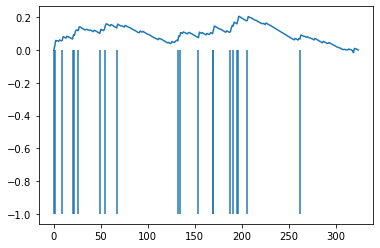

In [55]:
warnings.filterwarnings('ignore')

def bridge_plot(select: pd.Series, weights: pd.Series = None):
    #Use the filter to construct a bridge plot.

    if weights is None:
        weights = pd.Series(np.ones(select.shape[0]), index=select.index)
    
    max_es = weights[select].abs().sum() # maximum enrichment score if we were to hit everything (positively)
    up = select * weights / max_es # go up/dn by normalized weight on each hit
    dn = - (1 - select) * up.sum() / (~select).sum()
    x = np.arange(select.shape[0]+1)
    y = np.concatenate([
    np.zeros(1),
    np.cumsum(up + dn),])
    return x, y

# assign directory
directory = 'up_down'

file_list = list()
# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        file_list.append(f)

# Gather all up and down target genes of Morphine from ENRICHR GMT files
for file in file_list:
    up_list = list()
    down_list = list()

    if "up" in file:
        f = open(file, encoding='windows-1252')
        for row in f:
          row_list = row.split("\t")
          count = 0
          for gene in row_list:
            if count == 0:
              count += 1
            else:
              up_list.append(gene)
        f.close()

    if "down" in file:
        f = open(file, encoding='windows-1252')
        for row in f:
          row_list = row.split("\t")
          count = 0
          for gene in row_list:
            if count == 0:
              count += 1
            else:
              down_list.append(gene)
        f.close()

# Generate Bridge Plots Coordinates
average_bridge = list()
f = open("GMT_General_Non_Other.tsv", "r")
for row in f:
    select_up = list()
    select_down = list()

    row_list = row.split("\t")
    sig_name = row_list[:1]
    gene_list = row_list[1:]

    if "up" in sig_name[0]:
        for gene in gene_list:
          if gene in up_list:
            select_up.append(1)
          else:
            select_up.append(0)

    else:
        for gene in gene_list:
          if gene in down_list:
            select_down.append(1)
          else:
            select_down.append(0)

    select_up = pd.Series(select_up) == 1
    select_down = pd.Series(select_down) == 1

    x, y = bridge_plot(select_down)
    average_bridge.append(y.tolist())        
f.close()

# Average Bridge Plots
average_list = list()
for bridge_coord in average_bridge:
    if len(bridge_coord) > 1:
        for num in range(0, len(bridge_coord)):
            try:
                average_list[num] = (average_list[num] + bridge_coord[num])/2
            except:
                average_list.append(bridge_coord[num])

x = list()
for coord in range(0, len(average_list)):
    x.append(coord)

plt.plot(x, average_list)
plt.vlines(np.argwhere(select_down.values)[:, 0], ymin=-1, ymax=0)
plt.savefig('GMT_General_Non_Other.png')
